In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from tensorflow.keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


# Load data

In [ ]:


train_dataset_path = os.path.join('data/', f'train_FD001.txt')
train_data = pd.read_csv(train_dataset_path, delimiter='\s+', header=None)


test_dataset_path = os.path.join('data/',  f'test_FD001.txt')
test_data = pd.read_csv(test_dataset_path, delimiter='\s+', header=None)


rul_dataset_path = os.path.join('data/', f'RUL_FD001.txt')
rul_data = pd.read_csv(rul_dataset_path, delimiter='\s+', header=None)

In [3]:
columns_train = ['Engine_ID','cycle','setting_1','setting_2','setting_3','S1','S2','S3','S4','S5','S6','S7','S8',
           'S9','S10','S11','S12','S13','S14','S15','S16','S17','S18','S19','S20','S21' ]
train_data.columns = columns_train

# pre-processing

In [ ]:
# feature extraction
#choose Sensors that have monotonic trend
sensor_indices = [6, 7, 8, 11, 15, 16, 19, 24, 25]
sensor_data = train_data.iloc[:, sensor_indices].values

In [ ]:
# Normalize each sensor
scaler = MinMaxScaler(feature_range=(0, 1))
sensor_data_scaled = scaler.fit_transform(sensor_data)

In [6]:
sensor_data_scaled_df = pd.DataFrame(sensor_data_scaled)
sensor_data_scaled_df

,0,1,2,3,4,5,6,7,8
0,0.183735,0.406802,0.309757,0.726248,0.369048,0.633262,0.363986,0.713178,0.724662
1,0.283133,0.453019,0.352633,0.628019,0.380952,0.765458,0.411312,0.666667,0.731014
2,0.343373,0.369523,0.370527,0.710145,0.250000,0.795309,0.357445,0.627907,0.621375
3,0.343373,0.256159,0.331195,0.740741,0.166667,0.889126,0.166603,0.573643,0.662386
4,0.349398,0.257467,0.404625,0.668277,0.255952,0.746269,0.402078,0.589147,0.704502
...,...,...,...,...,...,...,...,...,...
20626,0.686747,0.587312,0.782917,0.254428,0.726190,0.170576,0.656791,0.271318,0.109500
20627,0.701807,0.729453,0.866475,0.162641,0.708333,0.211087,0.727203,0.124031,0.366197
20628,0.665663,0.684979,0.775321,0.175523,0.738095,0.281450,0.922278,0.232558,0.053991
20629,0.608434,0.746021,0.747468,0.133655,0.916667,0.208955,0.823394,0.116279,0.234466


## RUL Labeling

In [ ]:


# Compute RUL for Each Unit
units = train_data.iloc[:, 0].unique()
rul_list = []
for unit in units:
    unit_data = train_data[train_data.iloc[:, 0] == unit]
    max_cycle = unit_data.iloc[:, 1].max()
    rul_unit = max_cycle - unit_data.iloc[:, 1]
    rul_list.extend(rul_unit.values)
rul = np.array(rul_list)

# for early cycles -> cap the RUL at 97 cycles.
initial_rul = 97
rul_capped = np.where(rul > initial_rul, initial_rul, rul)

In [8]:
df = pd.DataFrame(rul_capped)
sensor_data_scaled_df['RUL']= rul_capped
sensor_data_scaled_df['cycle unit']=train_data['cycle']
sensor_data_scaled_df

,0,1,2,3,4,5,6,7,8,RUL,cycle unit
0,0.183735,0.406802,0.309757,0.726248,0.369048,0.633262,0.363986,0.713178,0.724662,97,1
1,0.283133,0.453019,0.352633,0.628019,0.380952,0.765458,0.411312,0.666667,0.731014,97,2
2,0.343373,0.369523,0.370527,0.710145,0.250000,0.795309,0.357445,0.627907,0.621375,97,3
3,0.343373,0.256159,0.331195,0.740741,0.166667,0.889126,0.166603,0.573643,0.662386,97,4
4,0.349398,0.257467,0.404625,0.668277,0.255952,0.746269,0.402078,0.589147,0.704502,97,5
...,...,...,...,...,...,...,...,...,...,...,...
20626,0.686747,0.587312,0.782917,0.254428,0.726190,0.170576,0.656791,0.271318,0.109500,4,196
20627,0.701807,0.729453,0.866475,0.162641,0.708333,0.211087,0.727203,0.124031,0.366197,3,197
20628,0.665663,0.684979,0.775321,0.175523,0.738095,0.281450,0.922278,0.232558,0.053991,2,198
20629,0.608434,0.746021,0.747468,0.133655,0.916667,0.208955,0.823394,0.116279,0.234466,1,199


In [ ]:

sensor_data_scaled_df = sensor_data_scaled_df.drop(columns=['cycle unit'])
sensor_data_scaled_df

,0,1,2,3,4,5,6,7,8,RUL
0,0.183735,0.406802,0.309757,0.726248,0.369048,0.633262,0.363986,0.713178,0.724662,97
1,0.283133,0.453019,0.352633,0.628019,0.380952,0.765458,0.411312,0.666667,0.731014,97
2,0.343373,0.369523,0.370527,0.710145,0.250000,0.795309,0.357445,0.627907,0.621375,97
3,0.343373,0.256159,0.331195,0.740741,0.166667,0.889126,0.166603,0.573643,0.662386,97
4,0.349398,0.257467,0.404625,0.668277,0.255952,0.746269,0.402078,0.589147,0.704502,97
...,...,...,...,...,...,...,...,...,...,...
20626,0.686747,0.587312,0.782917,0.254428,0.726190,0.170576,0.656791,0.271318,0.109500,4
20627,0.701807,0.729453,0.866475,0.162641,0.708333,0.211087,0.727203,0.124031,0.366197,3
20628,0.665663,0.684979,0.775321,0.175523,0.738095,0.281450,0.922278,0.232558,0.053991,2
20629,0.608434,0.746021,0.747468,0.133655,0.916667,0.208955,0.823394,0.116279,0.234466,1


# Train model

In [10]:
X = sensor_data_scaled_df.drop('RUL', axis=1).values
y = sensor_data_scaled_df['RUL'].values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## linear regression model

In [ ]:

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:

y_lr_train_prediction=model.predict(X_train)
y_lr_test_prediction=model.predict(X_test)

#print(y_lr_train_prediction,y_lr_test_prediction)

## Random Forest Model with GridSearch

In [ ]:

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [2,4]
min_samples_split = [2, 5]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

In [ ]:

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [ ]:
from sklearn.ensemble import RandomForestRegressor

grid_search = GridSearchCV(RandomForestRegressor(),
                           param_grid=param_grid,
                           cv=5, 
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72,
                                          80]})

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf_Model = RandomForestRegressor()

rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 3, verbose=2, n_jobs = 4)


rf_Grid.fit(X_train, y_train)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72,
                                          80]},
             verbose=2)

In [18]:
rf_Grid.best_params_

{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 80}

In [19]:
rf_Grid.best_estimator_

RandomForestRegressor(max_depth=4, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=80)

In [20]:
y_rf_train_pred = rf_Grid.predict(X_train)
y_rf_test_pred = rf_Grid.predict(X_test)

In [ ]:
import pickle


with open('rf_model_1.pkl', 'wb') as file:
    pickle.dump(rf_Grid, file)

## SVR model

In [ ]:
from sklearn.svm import SVR


svr_model = SVR(kernel='rbf', gamma=0.5, C=10, epsilon=0.05)

svr_model.fit(X_train, y_train)

SVR(C=10, epsilon=0.05, gamma=0.5)

In [23]:
from sklearn.svm import SVR
param_grid_svr = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'epsilon': [0.01, 0.1, 0.5, 1]
}
grid_search_svr = GridSearchCV(SVR(kernel='rbf'), param_grid=param_grid_svr, cv=5, n_jobs=-1)
grid_search_svr.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'epsilon': [0.01, 0.1, 0.5, 1],
                         'gamma': ['scale', 'auto', 0.1, 0.01, 0.001]})

In [78]:
grid_search_svr.best_estimator_

SVR(C=100, epsilon=1, gamma='auto')

In [24]:
y_svr_train_pred = grid_search_svr.predict(X_train)
y_svr_test_pred = grid_search_svr.predict(X_test)

In [ ]:
import pickle

with open('svr_model_1.pkl', 'wb') as file:
    pickle.dump(grid_search_svr, file)

## FeedForward NN

In [ ]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2


def create_model(input_shape):
    model = keras.Sequential([
        layers.Dense(128, activation="relu", input_shape=(input_shape,)),
        layers.BatchNormalization(),  
        layers.Dropout(0.2),
        
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),  
        layers.Dropout(0.2),
        
        layers.Dense(1)  # Output -> RUL 
    ])
    
    optimizer = keras.optimizers.Adam(learning_rate=0.00005)
    model.compile(optimizer=optimizer, loss="mse", metrics=['mae'])
    return model


lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

nn_model = create_model(X_train.shape[1])
nn_history = nn_model.fit(
        X_train, y_train, 
        epochs=100, batch_size=32, verbose=1, 
        validation_data=(X_test, y_test), 
        callbacks=[early_stop, lr_scheduler]
    )

Train on 16504 samples, validate on 4127 samples
Epoch 1/100
16504/16504 [==============================] - 4s 213us/sample - loss: 6197.7631 - mae: 73.5648 - val_loss: 6186.6252 - val_mae: 74.0454
Epoch 2/100
16504/16504 [==============================] - 2s 138us/sample - loss: 5936.1478 - mae: 73.1964 - val_loss: 5864.5176 - val_mae: 73.3794
Epoch 3/100
16504/16504 [==============================] - 2s 143us/sample - loss: 5778.7216 - mae: 72.7321 - val_loss: 5679.4500 - val_mae: 72.564574
Epoch 4/100
16504/16504 [==============================] - 2s 145us/sample - loss: 5629.3407 - mae: 72.1401 - val_loss: 5492.3839 - val_mae: 71.6980
Epoch 5/100
16504/16504 [==============================] - 2s 145us/sample - loss: 5469.5660 - mae: 71.4468 - val_loss: 5344.8663 - val_mae: 71.0049
Epoch 6/100
16504/16504 [==============================] - 2s 148us/sample - loss: 5318.4415 - mae: 70.6793 - val_loss: 5239.3639 - val_mae: 70.5483: 5352
Epoch 7/100
16504/16504 [========================

In [43]:
y_nn_test_pred = nn_model.predict(X_test).flatten()
y_nn_train_pred = nn_model.predict(X_train).flatten()


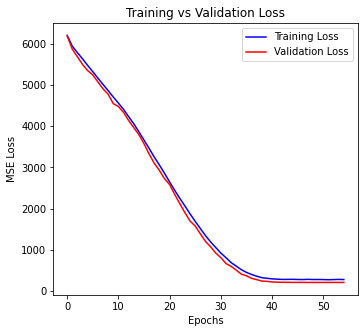

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(nn_history.history['loss'], label="Training Loss", color='blue')
plt.plot(nn_history.history['val_loss'], label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()

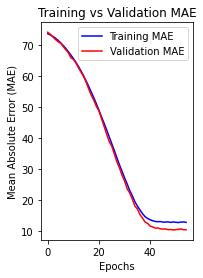

In [45]:
# Plot Training & Validation MAE
plt.subplot(1, 2, 2)
plt.plot(nn_history.history['mae'], label="Training MAE", color='blue')
plt.plot(nn_history.history['val_mae'], label="Validation MAE", color='red')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Training vs Validation MAE")
plt.legend()

plt.show()

In [ ]:
train_mae = nn_history.history['mae'][-1]
val_mae = nn_history.history['val_mae'][-1]
print(f"Final Training MAE: {train_mae:.2f}")
print(f"Final Validation MAE: {val_mae:.2f}")

if val_mae > train_mae * 1.5:
    print("⚠ Warning: Model may be overfitting. Consider adding regularization or dropout.")


Final Training MAE: 12.74
Final Validation MAE: 10.36


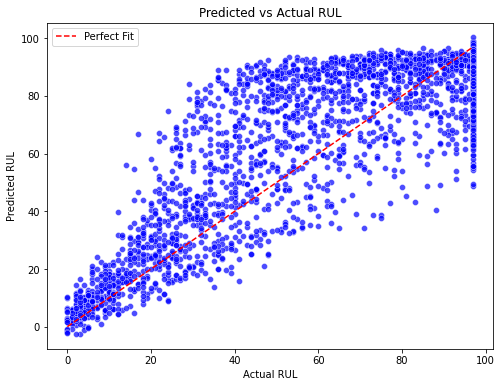

In [ ]:

y_nn_test_pred = nn_model.predict(X_test).flatten()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_nn_test_pred, alpha=0.7, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL")
plt.legend()
plt.show()


In [ ]:
sample_idx = 12  
predicted_rul = nn_model.predict(X_test[sample_idx].reshape(1, -1))
actual_rul = y_test[sample_idx]

print(f"Predicted RUL: {predicted_rul[0][0]:.2f}, Actual RUL: {actual_rul}")


Predicted RUL: 35.17, Actual RUL: 40


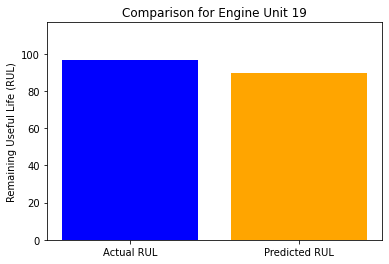

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sample_idx = 19  
predicted_rul = nn_model.predict(X_test[sample_idx].reshape(1, -1))
actual_rul = y_test[sample_idx]

# Plot
plt.bar(["Actual RUL", "Predicted RUL"], [actual_rul, predicted_rul[0][0]], color=['blue', 'orange'])
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"Comparison for Engine Unit {sample_idx}")
plt.ylim(0, max(actual_rul, predicted_rul[0][0]) + 20)
plt.show()


In [50]:
test_loss, test_mae = nn_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


4127/4127 [==============================] - 0s 113us/sample - loss: 209.5724 - mae: 10.3022
Test Loss: 209.57239967089228, Test MAE: 10.302154541015625


# Evaluate The Model

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

lr_train_mse=mean_squared_error(y_train,y_lr_train_prediction)
lr_train_r2=r2_score(y_train,y_lr_train_prediction)

lr_test_mse=mean_squared_error(y_test,y_lr_test_prediction)
lr_test_r2=r2_score(y_test,y_lr_test_prediction)


lr_rmse_train = np.sqrt(mean_squared_error(y_train, y_lr_train_prediction))
lr_rmse_test = np.sqrt(mean_squared_error(y_test, y_lr_test_prediction))

print('LR MSE (Train)',lr_train_mse)
print('LR R2 (Train)',lr_train_r2)
print('LR RMSE (Train)',lr_rmse_train)

print('LR MSE (Test)',lr_test_mse)
print('LR R2 (Test)',lr_test_r2)
print('LR RMSE (Test)',lr_rmse_test)

LR MSE (Train) 287.840012971155
LR R2 (Train) 0.7043253084592217
LR RMSE (Train) 16.96584843063131
LR MSE (Test) 291.6843274680559
LR R2 (Test) 0.6891987289495902
LR RMSE (Test) 17.078768324093396


In [ ]:
lr_results=pd.DataFrame(['Linear regression',lr_train_mse,lr_train_r2,lr_rmse_train,lr_test_mse,lr_test_r2,lr_rmse_test]).transpose()

lr_results.columns=['Method','Training MSE','Training R2','Training RMSE','Test MSE','Test R2','Test RMSE']
lr_results

,Method,Training MSE,Training R2,Training RMSE,Test MSE,Test R2,Test RMSE
0,Linear regression,287.84,0.704325,16.9658,291.684,0.689199,17.0788


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error

rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
rf_train_r2 = r2_score(y_train, y_rf_train_pred)

rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)

rf_rmse_train = np.sqrt(mean_squared_error(y_train, y_rf_train_pred))
rf_rmse_test = np.sqrt(mean_squared_error(y_test, y_rf_test_pred))

print('RF MSE (Train)',rf_train_mse)
print('RF R2 (Train)',rf_train_r2)
print('RF RMSE (Train)',rf_rmse_train)

print('RF MSE (Test)',rf_test_mse)
print('RF R2 (Test)',rf_test_r2)
print('RF MSE (Test)',rf_rmse_test)

RF MSE (Train) 216.38642478163828
RF R2 (Train) 0.777723782247973
RF RMSE (Train) 14.710079020237732
RF MSE (Test) 227.18801436219204
RF R2 (Test) 0.7579221199708751
RF MSE (Test) 15.072757357636725


In [ ]:
rf_results = pd.DataFrame(['Random forest', rf_train_mse, rf_train_r2,rf_rmse_train, rf_test_mse, rf_test_r2,rf_rmse_test]).transpose()

rf_results.columns = ['Method','Training MSE','Training R2','Training RMSE','Test MSE','Test R2','Test RMSE']
rf_results

,Method,Training MSE,Training R2,Training RMSE,Test MSE,Test R2,Test RMSE
0,Random forest,216.386,0.777724,14.7101,227.188,0.757922,15.0728


In [ ]:
svr_train_mse = mean_squared_error(y_train, y_svr_train_pred)
svr_train_r2 = r2_score(y_train, y_svr_train_pred)

svr_test_mse = mean_squared_error(y_test, y_svr_test_pred)
svr_test_r2 = r2_score(y_test, y_svr_test_pred)

svr_rmse_train = np.sqrt(mean_squared_error(y_train, y_svr_train_pred))
svr_rmse_test = np.sqrt(mean_squared_error(y_test, y_svr_test_pred))

print('SVR MSE (Train)',svr_train_mse)
print('SVR R2 (Train)',svr_train_r2)
print('SVR RMSE (Train)',svr_rmse_train)

print('SVR MSE (Test)',svr_test_mse)
print('SVR R2 (Test)',svr_test_r2)
print('SVR MSE (Test)',svr_rmse_test)

SVR MSE (Train) 223.8859601652557
SVR R2 (Train) 0.7700201180201909
SVR RMSE (Train) 14.962819258590798
SVR MSE (Test) 228.33027094562357
SVR R2 (Test) 0.7567050000759603
SVR MSE (Test) 15.110601276773323


In [ ]:
svr_results = pd.DataFrame(['Support Vector Regression', svr_train_mse, svr_train_r2,svr_rmse_train, svr_test_mse, svr_test_r2,svr_rmse_test]).transpose()

svr_results.columns = ['Method','Training MSE','Training R2','Training RMSE','Test MSE','Test R2','Test RMSE']
svr_results

,Method,Training MSE,Training R2,Training RMSE,Test MSE,Test R2,Test RMSE
0,Support Vector Regression,223.886,0.77002,14.9628,228.33,0.756705,15.1106


In [ ]:


nn_train_mse = mean_squared_error(y_train, y_nn_train_pred)
nn_train_r2 = r2_score(y_train, y_nn_train_pred)

nn_test_mse = mean_squared_error(y_test, y_nn_test_pred)
nn_test_r2 = r2_score(y_test, y_nn_test_pred)


nn_rmse_train = np.sqrt(mean_squared_error(y_train, y_nn_train_pred))
nn_rmse_test = np.sqrt(mean_squared_error(y_test, y_nn_test_pred))

print('NN MSE (Train)',nn_train_mse)
print('NN R2 (Train)',nn_train_r2)
print('NN RMSE (Train)',nn_rmse_train)

print('SVR MSE (Test)',nn_test_mse)
print('SVR R2 (Test)',nn_test_r2)
print('SVR MSE (Test)',nn_rmse_test)

NN MSE (Train) 204.67822508302237
NN R2 (Train) 0.7897506658582548
NN RMSE (Train) 14.306579782848953
SVR MSE (Test) 209.572399569042
SVR R2 (Test) 0.7766922593046212
SVR MSE (Test) 14.476615611704347


In [ ]:
nn_results = pd.DataFrame(['Neural Network', nn_train_mse, nn_train_r2,nn_rmse_train, nn_test_mse, nn_test_r2,nn_rmse_test]).transpose()
nn_results.columns = ['Method','Training MSE','Training R2','Training RMSE','Test MSE','Test R2','Test RMSE']
nn_results

,Method,Training MSE,Training R2,Training RMSE,Test MSE,Test R2,Test RMSE
0,Neural Network,204.678,0.789751,14.3066,209.572,0.776692,14.4766


# Model comparison

In [59]:
#combined the reults from the 3 models in the same table
data_frame_models = pd.concat([lr_results, rf_results,svr_results,nn_results], axis=0).reset_index(drop=True)

In [60]:
data_frame_models

,Method,Training MSE,Training R2,Training RMSE,Test MSE,Test R2,Test RMSE
0,Linear regression,287.84,0.704325,16.9658,291.684,0.689199,17.0788
1,Random forest,216.386,0.777724,14.7101,227.188,0.757922,15.0728
2,Support Vector Regression,223.886,0.77002,14.9628,228.33,0.756705,15.1106
3,Neural Network,204.678,0.789751,14.3066,209.572,0.776692,14.4766


In [ ]:
import pandas as pd

def highlight_min(s):
    """Highlight the minimum value in a column."""
    is_min = s == s.min()
    return ['font-weight: bold' if cell else '' for cell in is_min]

def highlight_max(s):
    """Highlight the maximum value in a column."""
    is_max = s == s.max()
    return ['font-weight: bold' if cell else '' for cell in is_max]

best_styled = (
    data_frame_models.style
    .apply(highlight_min, subset=['Training MSE', 'Training RMSE', 'Test MSE', 'Test RMSE'])
    .apply(highlight_max, subset=['Training R2', 'Test R2'])
)

best_styled


,Method,Training MSE,Training R2,Training RMSE,Test MSE,Test R2,Test RMSE
0,Linear regression,287.840013,0.704325,16.965848,291.684327,0.689199,17.078768
1,Random forest,216.386425,0.777724,14.710079,227.188014,0.757922,15.072757
2,Support Vector Regression,223.885960,0.770020,14.962819,228.330271,0.756705,15.110601
3,Neural Network,204.678225,0.789751,14.306580,209.572400,0.776692,14.476616


# Data visualization of prediction results

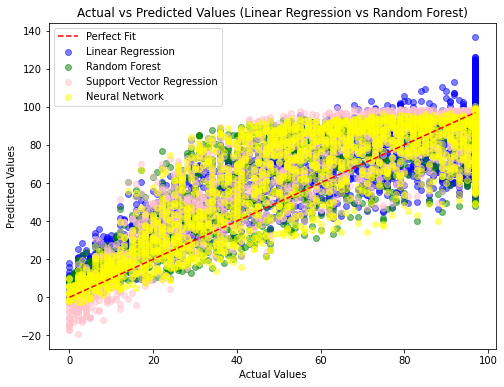

In [62]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_lr_test_prediction, alpha=0.5, label="Linear Regression", color='blue')
plt.scatter(y_test, y_rf_test_pred, alpha=0.5, label="Random Forest", color='green')
plt.scatter(y_test, y_svr_test_pred, alpha=0.5, label="Support Vector Regression", color='pink')
plt.scatter(y_test, y_nn_test_pred, alpha=0.5, label="Neural Network", color='yellow')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed', label="Perfect Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values (Linear Regression vs Random Forest)")
plt.legend()
plt.show()


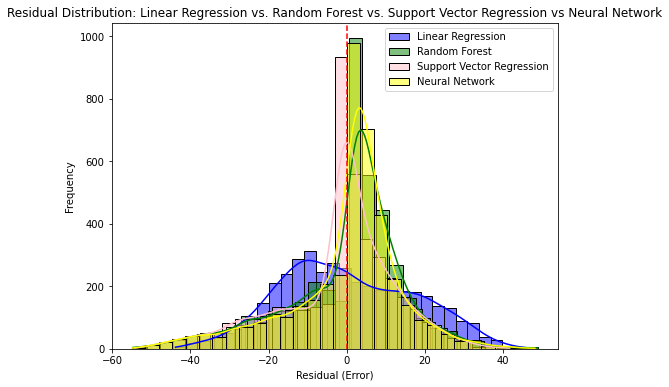

In [ ]:
import seaborn as sns


residuals_lr = y_test - y_lr_test_prediction
residuals_rf = y_test - y_rf_test_pred
residuals_svr = y_test - y_svr_test_pred
residuals_nn = y_test - y_nn_test_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals_lr, bins=30, kde=True, color='blue', label="Linear Regression")
sns.histplot(residuals_rf, bins=30, kde=True, color='green', label="Random Forest")
sns.histplot(residuals_svr, bins=30, kde=True, color='pink', label="Support Vector Regression")
sns.histplot(residuals_nn, bins=30, kde=True, color='yellow', label="Neural Network")
plt.axvline(x=0, color='red', linestyle='dashed')
plt.xlabel("Residual (Error)")
plt.ylabel("Frequency")
plt.title("Residual Distribution: Linear Regression vs. Random Forest vs. Support Vector Regression vs Neural Network")
plt.legend()
plt.show()


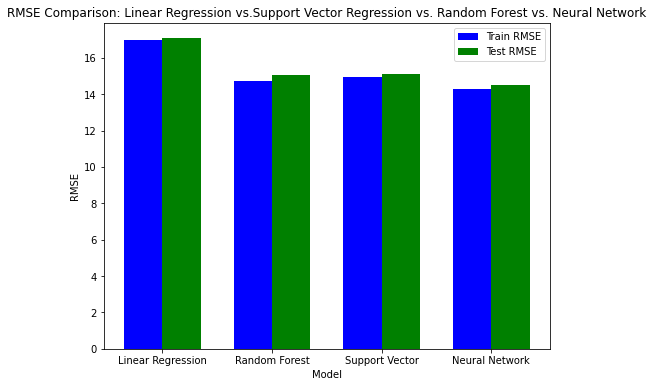

In [ ]:
import numpy as np



models = ["Linear Regression", "Random Forest","Support Vector","Neural Network",]
train_rmse = [lr_rmse_train, rf_rmse_train,svr_rmse_train,nn_rmse_train]
test_rmse = [lr_rmse_test, rf_rmse_test,svr_rmse_test,nn_rmse_test]

x = np.arange(len(models))
width = 0.35 

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, train_rmse, width, label="Train RMSE", color='blue')
plt.bar(x + width/2, test_rmse, width, label="Test RMSE", color='green')
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("RMSE Comparison: Linear Regression vs.Support Vector Regression vs. Random Forest vs. Neural Network")
plt.xticks(x, models)
plt.legend()
plt.show()


# Compute Confidence Interval using Bootstrapping

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def bootstrap_metric(y_true, y_pred, metric_func, n_bootstrap=1000, ci=95, random_state=42):
    """
    Computes bootstrap confidence intervals for the provided regression metric.
    
    Parameters:
    y_true: true target values
    y_pred: predicted values
    metric_func: function to compute metric (e.g., mean_squared_error)
    n_bootstrap: number of bootstrap samples
    ci: confidence interval level (default 95%)

    Returns:
    mean_metric: Mean metric value across bootstraps
    (lower_bound, upper_bound): Confidence interval bounds
    """
    n = len(y_true)
    rng = np.random.RandomState(random_state)
    bootstrap_scores = []
    
    for _ in range(n_bootstrap):
        indices = rng.randint(0, n, n)
        y_true_sample = y_true[indices]
        y_pred_sample = y_pred[indices]
        score = metric_func(y_true_sample, y_pred_sample)
        bootstrap_scores.append(score)

    lower, upper = np.percentile(bootstrap_scores, [(100-ci)/2, 100 - (100-ci)/2])
    mean_metric = np.mean(bootstrap_scores)
    return mean_metric, (lower, upper)


n_bootstrap = 1000
ci = 95

 

models_predictions = {
    'Linear Regression': y_lr_test_prediction,
    'Random Forest': y_rf_test_pred,
    'SVR': y_svr_test_pred,
    'Neural Network': y_nn_test_pred
}

results = {}
for model_name, y_pred in models_predictions.items():
    rmse_mean, rmse_ci = bootstrap_metric(y_test, y_pred, 
                                          metric_func=lambda y, y_hat: np.sqrt(mean_squared_error(y, y_hat)),
                                          n_bootstrap=n_bootstrap, ci=ci)
    
    mae_mean, mae_ci = bootstrap_metric(y_test, y_pred, 
                                         metric_func=mean_absolute_error,
                                         n_bootstrap=n_bootstrap, ci=ci)
    
    r2_mean, r2_ci = bootstrap_metric(y_test, y_pred, 
                                      metric_func=r2_score,
                                      n_bootstrap=n_bootstrap, ci=ci)
    
    print(f"{model_name} RMSE: {rmse_mean:.2f}, CI: {rmse_ci}")
    print(f"{model_name} MAE: {mae_mean:.2f}, CI: {mae_ci}")
    print(f"{model_name} R²: {r2_mean:.2f}, CI: {r2_ci}")


Linear Regression RMSE: 17.07, CI: (16.76324532314481, 17.361723763227925)
Linear Regression MAE: 14.16, CI: (13.876866989237929, 14.439914961154447)
Linear Regression R²: 0.69, CI: (0.6727835054243223, 0.7060124304484248)
Random Forest RMSE: 15.07, CI: (14.660263762533381, 15.484050147398706)
Random Forest MAE: 11.18, CI: (10.86318282949835, 11.482617114917938)
Random Forest R²: 0.76, CI: (0.7421679936162137, 0.7731299127477359)
SVR RMSE: 15.11, CI: (14.696424726533234, 15.501625667735482)
SVR MAE: 10.55, CI: (10.212671855980906, 10.873575463768637)
SVR R²: 0.76, CI: (0.741526189090747, 0.7722234287387344)
Neural Network RMSE: 14.48, CI: (14.037899179934996, 14.893249951709194)
Neural Network MAE: 10.30, CI: (9.978979015112039, 10.602209833665132)
Neural Network R²: 0.78, CI: (0.760713050209781, 0.7922192814915646)


Comparison Table of Confidence Intervals for Each Model and Metric:
                Model Metric       Mean   CI Lower   CI Upper  CI Width
0   Linear Regression   RMSE  17.074617  16.763245  17.361724  0.598478
1   Linear Regression    MAE  14.164115  13.876867  14.439915  0.563048
2   Linear Regression     R2   0.688958   0.672784   0.706012  0.033229
3       Random Forest   RMSE  15.071189  14.660264  15.484050  0.823786
4       Random Forest    MAE  11.180051  10.863183  11.482617  0.619434
5       Random Forest     R2   0.757645   0.742168   0.773130  0.030962
6                 SVR   RMSE  15.107341  14.696425  15.501626  0.805201
7                 SVR    MAE  10.549439  10.212672  10.873575  0.660904
8                 SVR     R2   0.756488   0.741526   0.772223  0.030697
9      Neural Network   RMSE  14.475242  14.037899  14.893250  0.855351
10     Neural Network    MAE  10.299610   9.978979  10.602210  0.623231
11     Neural Network     R2   0.776421   0.760713   0.792219  0.031

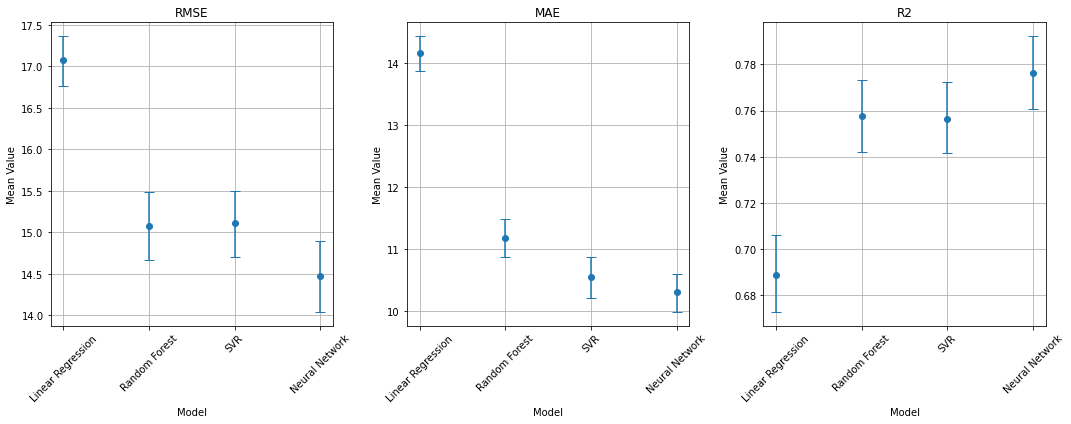

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def bootstrap_metric(y_true, y_pred, metric_func, n_bootstrap=1000, ci=95, random_state=42):
    n = len(y_true)
    rng = np.random.RandomState(random_state)
    bootstrap_scores = []
    
    for _ in range(n_bootstrap):
        indices = rng.randint(0, n, n)
        y_true_sample = y_true[indices]
        y_pred_sample = y_pred[indices]
        score = metric_func(y_true_sample, y_pred_sample)
        bootstrap_scores.append(score)

    lower, upper = np.percentile(bootstrap_scores, [(100-ci)/2, 100 - (100-ci)/2])
    mean_metric = np.mean(bootstrap_scores)
    return mean_metric, (lower, upper)


n_bootstrap = 1000
ci_level = 95


models_predictions = {
    'Linear Regression': y_lr_test_prediction,
    'Random Forest': y_rf_test_pred,
    'SVR': y_svr_test_pred,
    'Neural Network': y_nn_test_pred
}


results = {}
table_rows = [] 
for model_name, y_pred in models_predictions.items():

    rmse_mean, rmse_ci = bootstrap_metric(
        y_test, y_pred, 
        metric_func=lambda y, y_hat: np.sqrt(mean_squared_error(y, y_hat)),
        n_bootstrap=n_bootstrap, ci=ci_level
    )
    
    mae_mean, mae_ci = bootstrap_metric(
        y_test, y_pred, 
        metric_func=mean_absolute_error,
        n_bootstrap=n_bootstrap, ci=ci_level
    )
    
    r2_mean, r2_ci = bootstrap_metric(
        y_test, y_pred, 
        metric_func=r2_score,
        n_bootstrap=n_bootstrap, ci=ci_level
    )
    
    results[model_name] = {
        'RMSE': {'mean': rmse_mean, 'ci': rmse_ci},
        'MAE': {'mean': mae_mean, 'ci': mae_ci},
        'R2': {'mean': r2_mean, 'ci': r2_ci},
    }
    
    table_rows.append({
        'Model': model_name,
        'Metric': 'RMSE',
        'Mean': rmse_mean,
        'CI Lower': rmse_ci[0],
        'CI Upper': rmse_ci[1],
        'CI Width': rmse_ci[1] - rmse_ci[0]
    })
    table_rows.append({
        'Model': model_name,
        'Metric': 'MAE',
        'Mean': mae_mean,
        'CI Lower': mae_ci[0],
        'CI Upper': mae_ci[1],
        'CI Width': mae_ci[1] - mae_ci[0]
    })
    table_rows.append({
        'Model': model_name,
        'Metric': 'R2',
        'Mean': r2_mean,
        'CI Lower': r2_ci[0],
        'CI Upper': r2_ci[1],
        'CI Width': r2_ci[1] - r2_ci[0]
    })


df_results = pd.DataFrame(table_rows)
print("Comparison Table of Confidence Intervals for Each Model and Metric:")
print(df_results)


metrics = ['RMSE', 'MAE', 'R2']
fig, axes = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 6), sharey=False)

for i, metric in enumerate(metrics):
    ax = axes[i]

    subset = df_results[df_results['Metric'] == metric]
    models = subset['Model'].tolist()
    means = subset['Mean'].tolist()
    

    err_lower = [mean - lower for mean, lower in zip(means, subset['CI Lower'])]
    err_upper = [upper - mean for mean, upper in zip(means, subset['CI Upper'])]
    
    x_positions = np.arange(len(models))
    ax.errorbar(x_positions, means, yerr=[err_lower, err_upper], fmt='o', capsize=5, linestyle='None')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(models, rotation=45)
    ax.set_title(metric)
    ax.set_xlabel("Model")
    ax.set_ylabel("Mean Value")
    ax.grid(True)

plt.tight_layout()


plt.savefig('CI.png', dpi=300) 
plt.show()